<a href="https://colab.research.google.com/github/ondraperny/BI-BPR-2019/blob/master/MURA_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO
1. Find best way to load data fast and easy to work with
2. normalize brightness input images on same scale
3. Rescale or find region of interest and crop images.

# Mura dataset
Currently for testing purposes, just part of dataset is used. Specifically XR_HUMERUS data.

In [0]:
# import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)

#     except RuntimeError as e:
#         print(e)

# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [0]:
# print(device_lib.list_local_devices())

# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [0]:
# from wandb import magic

import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as k
from keras.preprocessing.image import ImageDataGenerator
import os
from glob import glob
%matplotlib inline

import sys
# check if code run on colab or local
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # Mount google drive
  from google.colab import drive
  drive.mount('/content/drive')

In [0]:
PATH_ORIGINAL_DATA="/content/drive/My Drive/SKOLA/Bachelor_work/XR_HUMERUS/"
PATH_MODELS="/content/drive/My Drive/SKOLA/Bachelor_work/Models/"

COMMON_PATH = "/content/drive/My Drive/SKOLA/Bachelor_work/preprocessed_data/"

PATH_DESTINATION_CROPPED_RECT = COMMON_PATH + "cropped_rect/"
PATH_DESTINATION_CROPPED_SQUARE = COMMON_PATH + "cropped_square/"

PATH_DESTINATION_HIST_EQ = COMMON_PATH + "hist_eq/"
PATH_DESTINATION_CLAHE = COMMON_PATH + "clahe/"

# cropped_rect_clahe shows so far best results, will be used in future
PATH_DESTINATION_CROPPED_RECT_CLAHE = COMMON_PATH + "cropped_rect_clahe/"
PATH_DESTINATION_CROPPED_SQUARE_CLAHE = COMMON_PATH + "cropped_square_clahe/"

PATH = PATH_DESTINATION_CROPPED_RECT_CLAHE

##  Constants declaration

In [0]:
if not IN_COLAB:
  # if run on local machine, change path to correspond my local system paths
  PATH = "G:"+PATH[14:].replace('/', '\\\\')

PATH_TRAIN = PATH + 'train'
PATH_VALID = PATH + 'valid'
IMG_SIZE=(224,224)
# TODO change image channel to 1 prob
INPUT_SHAPE = (*IMG_SIZE, 3)
BATCH_SIZE = 128
NUMBER_CLASSES = 2
NUMBER_EPOCHS = 20

# constants below not currently used
# TODO dataset size / batch size, or find better metrics
NUMBER_STEPS_PER_EPOCH = 62
# TODO same as above
NUMBER_VALIDATION_STEPS = 62

## Data augmentation
Currently image augmentation will be done by parameters of ImageDataGenerator.
If in future this solution will be insufficient, I will change it.

In [0]:
def ImageDataGenerator_def():
  datagen = ImageDataGenerator(
    # featurewise_center=False,  # set input mean to 0 over the dataset
    # samplewise_center=False,  # set each sample mean to 0
    # featurewise_std_normalization=False,  # divide inputs by std of the dataset
    # samplewise_std_normalization=False,  # divide each input by its std
    # zca_whitening=False,  # apply ZCA whitening
    # zca_epsilon=1e-06,  # epsilon for ZCA whitening
    # rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
    # # randomly shift images horizontally (fraction of total width)
    # width_shift_range=0.1,
    # # randomly shift images vertically (fraction of total height)
    # height_shift_range=0.1,
    # shear_range=0.,  # set range for random shear
    # zoom_range=0.,  # set range for random zoom
    # channel_shift_range=0.,  # set range for random channel shifts
    # # set mode for filling points outside the input boundaries
    # fill_mode='nearest',
    # cval=0.,  # value used for fill_mode = "constant"
    # horizontal_flip=True,  # randomly flip images
    # vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=1. / 255,
    # # set function that will be applied on each input
    # preprocessing_function=None,
    # # image data format, either "channels_first" or "channels_last"
    # data_format=None,
    # # fraction of images reserved for validation (strictly between 0 and 1)
    # validation_split=0.0
  )
  return datagen

def load_from_directory(dir_path):
  '''Load images from directory while transforming data (based on parameters),
  contain other parameters for data augmentation'''
  batches = data_generator.flow_from_directory(
    # path to target directory from which data will be loaded
    dir_path,
    # resize all input images to IMG_SIZE
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    # class_mode='categorical',
    # color_mode='grayscale'
  )
  return batches

In [5]:
data_generator = ImageDataGenerator_def()

train_batches = load_from_directory(PATH_TRAIN)
valid_batches = load_from_directory(PATH_VALID)

print("Found indices: ")
print(train_batches.class_indices)
# print(train_batches.class_indices)

Found 1271 images belonging to 2 classes.
Found 287 images belonging to 2 classes.
Found indices: 
{'train_negative': 0, 'train_positive': 1}


## Functions
Next block contains definitions of function for following code.

In [0]:
import matplotlib.cm as cm
def label_to_string(label):
  '''Map label value to descriptive string'''
  if(label == 0):
    return "Negative"
  else:
    return "Positive"

def show_sample_images():
  '''Show one batch of training images (max 25 images)'''
  image_batch, label_batch = train_batches.next()
  plt.figure(figsize=(10,10))
  for n in range(min(len(image_batch), 25)):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n][:,:,0], cmap=cm.gray)
    plt.title(label_to_string(label_batch[n]))
    plt.axis('off')
  plt.show()

image_batch, label_batch = train_batches.next()


ValueError: ignored

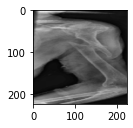

In [7]:
show_sample_images()

## Model definitions

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.optimizers import Adam

def basic_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
  model.add(Flatten())
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model

def simple_deep_CNN():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same', input_shape=INPUT_SHAPE))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(NUMBER_CLASSES))
  model.add(Activation('softmax'))
  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  return model


def three_block_VGG():
  # '''Three Block VGG Model'''
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=INPUT_SHAPE))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
	return model

def VGG16():
  vgg16 = keras.applications.vgg16.VGG16()
  model = Sequential()
  for layer in vgg16.layers:
    model.add(layer)
  model.layers.pop()
  # for layer in model.layers:
  #   layer.trainable = False
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
  return model

def densenet():
  """"""
  densenet_model = keras.applications.densenet.DenseNet201(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

import re
from keras.models import Model

def return_dense_2():
  return Dense(2, activation='softmax')

def insert_layer_nonseq(model, layer_regex, insert_layer_factory,
                        insert_layer_name=None, position='after'):

    # Auxiliary dictionary to describe the network graph
    network_dict = {'input_layers_of': {}, 'new_output_tensor_of': {}}

    # Set the input layers of each layer
    for layer in model.layers:
        for node in layer._outbound_nodes:
            layer_name = node.outbound_layer.name
            if layer_name not in network_dict['input_layers_of']:
                network_dict['input_layers_of'].update(
                        {layer_name: [layer.name]})
            else:
                network_dict['input_layers_of'][layer_name].append(layer.name)

    # Set the output tensor of the input layer
    network_dict['new_output_tensor_of'].update(
            {model.layers[0].name: model.input})

    # Iterate over all layers after the input
    for layer in model.layers[1:]:

        # Determine input tensors
        layer_input = [network_dict['new_output_tensor_of'][layer_aux] 
                for layer_aux in network_dict['input_layers_of'][layer.name]]
        if len(layer_input) == 1:
            layer_input = layer_input[0]

        # Insert layer if name matches the regular expression
        if re.match(layer_regex, layer.name):
            if position == 'replace':
                x = layer_input
            elif position == 'after':
                x = layer(layer_input)
            elif position == 'before':
                pass
            else:
                raise ValueError('position must be: before, after or replace')

            new_layer = insert_layer_factory()
            if insert_layer_name:
                new_layer.name = insert_layer_name
            else:
                new_layer.name = '{}_{}'.format(layer.name, 
                                                new_layer.name)
            x = new_layer(x)
            print('Layer {} inserted after layer {}'.format(new_layer.name,
                                                            layer.name))
            if position == 'before':
                x = layer(x)
        else:
            x = layer(layer_input)

        # Set new output tensor (the original one, or the one of the inserted
        # layer)
        network_dict['new_output_tensor_of'].update({layer.name: x})

    return Model(inputs=model.inputs, outputs=x)

densenet_model = insert_layer_nonseq(densenet_model, 'fc1000', return_dense_2, insert_layer_name='Dense_2', position='replace')



NameError: ignored

In [9]:
# model = three_block_VGG()
model = VGG16()
model.summary()













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
______________

In [10]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger(PATH+'augmented_log.csv', append=True, separator=';')

model.fit_generator(train_batches,
                    steps_per_epoch= len(train_batches),
                    validation_data = valid_batches,
                    validation_steps = len(valid_batches),
                    epochs = NUMBER_EPOCHS,
                    callbacks=[csv_logger])



Epoch 1/20
10/10 [==============================] - 236s 24s/step - loss: 0.6924 - acc: 0.5295 - val_loss: 0.6929 - val_acc: 0.5122
Epoch 2/20
10/10 [==============================] - 239s 24s/step - loss: 0.6917 - acc: 0.5293 - val_loss: 0.6930 - val_acc: 0.5122
Epoch 3/20
10/10 [==============================] - 233s 23s/step - loss: 0.6916 - acc: 0.5301 - val_loss: 0.6931 - val_acc: 0.5122
Epoch 4/20
10/10 [==============================] - 231s 23s/step - loss: 0.6915 - acc: 0.5298 - val_loss: 0.6931 - val_acc: 0.5122
Epoch 5/20
10/10 [==============================] - 232s 23s/step - loss: 0.6915 - acc: 0.5293 - val_loss: 0.6932 - val_acc: 0.5122
Epoch 6/20
10/10 [==============================] - 228s 23s/step - loss: 0.6914 - acc: 0.5295 - val_loss: 0.6932 - val_acc: 0.5122
Epoch 7/20
 1/10 [==>...........................] - ETA: 3:20 - loss: 0.6977 - acc: 0.4688

KeyboardInterrupt: ignored

In [0]:
# model.save(PATH_MODELS+"three_block_VGG.h5")

In [0]:
# from keras.models import load_model
# loaded_model = load_model(PATH_MODELS+"origin_model.h5")

In [0]:
# from keras.utils import plot_model
# plot_model(loaded_model, to_file=PATH_MODELS+"model_arch.png", show_shapes=True)

In [0]:
densenet_model = keras.applications.densenet.DenseNet201(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

# my_densenet = Sequential()
# for layer in densenet_model.layers[:-1]:
#   print(layer)
#   my_densenet.add(layer)

# # for layer in my_densenet.layers:
# #   layer.trainable = False

# densenet_model.add(Dense(2, activation='softmax'))

# my_densenet.summary()


import re
from keras.models import Model

def return_dense_2():
  return Dense(2, activation='softmax')

def insert_layer_nonseq(model, layer_regex, insert_layer_factory,
                        insert_layer_name=None, position='after'):

    # Auxiliary dictionary to describe the network graph
    network_dict = {'input_layers_of': {}, 'new_output_tensor_of': {}}

    # Set the input layers of each layer
    for layer in model.layers:
        for node in layer._outbound_nodes:
            layer_name = node.outbound_layer.name
            if layer_name not in network_dict['input_layers_of']:
                network_dict['input_layers_of'].update(
                        {layer_name: [layer.name]})
            else:
                network_dict['input_layers_of'][layer_name].append(layer.name)

    # Set the output tensor of the input layer
    network_dict['new_output_tensor_of'].update(
            {model.layers[0].name: model.input})

    # Iterate over all layers after the input
    for layer in model.layers[1:]:

        # Determine input tensors
        layer_input = [network_dict['new_output_tensor_of'][layer_aux] 
                for layer_aux in network_dict['input_layers_of'][layer.name]]
        if len(layer_input) == 1:
            layer_input = layer_input[0]

        # Insert layer if name matches the regular expression
        if re.match(layer_regex, layer.name):
            if position == 'replace':
                x = layer_input
            elif position == 'after':
                x = layer(layer_input)
            elif position == 'before':
                pass
            else:
                raise ValueError('position must be: before, after or replace')

            new_layer = insert_layer_factory()
            if insert_layer_name:
                new_layer.name = insert_layer_name
            else:
                new_layer.name = '{}_{}'.format(layer.name, 
                                                new_layer.name)
            x = new_layer(x)
            print('Layer {} inserted after layer {}'.format(new_layer.name,
                                                            layer.name))
            if position == 'before':
                x = layer(x)
        else:
            x = layer(layer_input)

        # Set new output tensor (the original one, or the one of the inserted
        # layer)
        network_dict['new_output_tensor_of'].update({layer.name: x})

    return Model(inputs=model.inputs, outputs=x)

densenet_model = insert_layer_nonseq(densenet_model, 'fc1000', return_dense_2, insert_layer_name='Dense_2', position='replace')

densenet_model.summary()

Layer Dense_2 inserted after layer fc1000
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[1][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[1][0]                 
__________________________________________________

In [0]:
  densenet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger(PATH+'augmented_log.csv', append=True, separator=';')

densenet_model.fit_generator(train_batches,
                    steps_per_epoch= len(train_batches),
                    validation_data = valid_batches,
                    validation_steps = len(valid_batches),
                    epochs = NUMBER_EPOCHS,
                    callbacks=[csv_logger])

Epoch 1/20
10/10 [==============================] - 1221s 122s/step - loss: 0.7697 - accuracy: 0.6601 - val_loss: 392.4830 - val_accuracy: 0.4878
Epoch 2/20
10/10 [==============================] - 1399s 140s/step - loss: 0.4571 - accuracy: 0.8057 - val_loss: 2376.4138 - val_accuracy: 0.4878
Epoch 3/20
10/10 [==============================] - 1355s 135s/step - loss: 0.3264 - accuracy: 0.8615 - val_loss: 1901.6975 - val_accuracy: 0.4878
Epoch 4/20
10/10 [==============================] - 1325s 132s/step - loss: 0.2396 - accuracy: 0.8938 - val_loss: 12.2392 - val_accuracy: 0.5296
Epoch 5/20
10/10 [==============================] - 1308s 131s/step - loss: 0.1790 - accuracy: 0.9284 - val_loss: 18.9628 - val_accuracy: 0.4878
Epoch 6/20
10/10 [==============================] - 1382s 138s/step - loss: 0.1198 - accuracy: 0.9583 - val_loss: 5.5835 - val_accuracy: 0.4878
Epoch 7/20
10/10 [==============================] - 1308s 131s/step - loss: 0.1017 - accuracy: 0.9599 - val_loss: 1.7741 - val

In [0]:
densenet_model.save(PATH+"origin_model.h5")